# Multicompartmental model - ball (soma) and stick (dendrite)

We define and then numerically simulate a multicompartmental model, where the geometry describes an active soma and a passive dendrtie. A current-clamp microelectrode, stimulating intracellularly by a step-wise DC waveform of amplitude $I_{stim}(t)$ is also *inserted* inside the membrane at the soma, while a conductance-based synapse is located at the distal end of the dendrite.

In [6]:
#@title NEURON install (launch only once)
# Note: Google Colab gives you access to an "instance".
# This is a virtual machine ("container" would be more correct) that runs
# Linux with already a Python installation.
!pip install neuron

In [7]:
#@title Create a *.mod file (Wang-Buzsaki) - launch only once
# Taken from ModelDB (https://modeldb.science/118631)
# https://modeldb.science/getModelFile?model=118631&file=KoendgenEtAl2008/mechanisms/wb.mod
%%writefile wb.mod
TITLE Wang Buzsaki Model
:
:
:

INDEPENDENT {t FROM 0 TO 1 WITH 1 (ms)}

NEURON {
    SUFFIX wb
    USEION na READ ena WRITE ina
    USEION k READ ek WRITE ik
    RANGE gnabar, gkbar, vth
    RANGE m_inf, h_inf, n_inf
    RANGE tau_h, tau_n
    RANGE h_exp, n_exp
}


UNITS {
    (mA) = (milliamp)
    (mV) = (millivolt)
}

PARAMETER {
    gnabar  = .07  (mho/cm2)
    gkbar   = .09  (mho/cm2)

    ena = 55    (mV)
    ek  = -90   (mV)
    celsius = 36    (degC)
    dt              (ms)
    v               (mV)

    vth = 0
}

STATE {
    h n
}

ASSIGNED {
    ina (mA/cm2)
    ik  (mA/cm2)
    il  (mA/cm2)
    m_inf
    h_inf
    n_inf
    tau_h
    tau_n
    h_exp
    n_exp
    tadj
}


BREAKPOINT {
    SOLVE states
    ina = gnabar * m_inf*m_inf*m_inf*h * (v - ena)
    ik  = gkbar * n*n*n*n * (v - ek)
}


:DERIVATIVE states {   : exact Hodgkin-Huxley equations
:   evaluate_fct(v)
:   m' = (m_inf - m) / tau_m
:   h' = (h_inf - h) / tau_h
:   n' = (n_inf - n) / tau_n
:}

PROCEDURE states() {    : exact when v held constant
    evaluate_fct(v)
    h = h + h_exp * (h_inf - h)
    n = n + n_exp * (n_inf - n)
    VERBATIM
    return 0;
    ENDVERBATIM
}

UNITSOFF
INITIAL {
    h = 0
    n = 0
:
:  Q10 was assumed to be 3 for both currents
:
: original measurements at roomtemperature?
:    tadj = 3.0 ^ ((celsius-36)/ 10 )
}

PROCEDURE evaluate_fct(v(mV)) { LOCAL a,b
    tadj = 1.

    if (v == -35) { a = 1
    }else{          a = -0.1 * (v+35.) / ( exp(-(v+35)/10.) - 1) }
    b = 4. * exp(-(v+60.)/18.)
    m_inf = a / (a + b)

    a = 0.007 * exp(-0.05*(v+58.))
    b = 1. / ( 1 + exp(-(v+28)/10.) )
    tau_h = (1. / (a + b)) / tadj
    h_inf = a / (a + b)

    if (v == -34) { a = 0.1
    }else{          a = -0.01 * (v+34.) / ( exp(-(v+34)/10.) - 1) }
    b = 0.125 * exp(-0.0125*(v+44))
    tau_n = (1. / (a + b)) / tadj
    n_inf = a / (a + b)

    h_exp = 1 - exp(-dt/tau_h)
    n_exp = 1 - exp(-dt/tau_n)
}

UNITSON

Overwriting wb.mod


In [ ]:
#@title Compile the .mod file - launch only once and then restart the restart the Colab runtime. Go to Runtime -> Restart runtime
# Compile the .mod file. This creates a directory named x86_64.
!nrnivmodl

/content
cfiles =
Mod files: "h.mod" "kdr.mod" "nav.mod" "wb.mod"

MODOBJS= ./h.o ./kdr.o ./nav.o ./wb.o
 -> Compiling mod_func.cpp
 -> NMODL ../h.mod
 -> NMODL ../wb.mod
Translating h.mod into /content/x86_64/h.cpp
Notice: Assignment to the GLOBAL variable, "linf", is not thread safe
Notice: Assignment to the GLOBAL variable, "taul", is not thread safe
Translating wb.mod into /content/x86_64/wb.cpp
 -> Compiling /content/x86_64/h.cpp
Notice: VERBATIM blocks are not thread safe
Notice: This mechanism cannot be used with CVODE
 -> Compiling /content/x86_64/wb.cpp
 => LINKING shared library "/content/x86_64/./libnrnmech.so"
Successfully created x86_64/special


In [ ]:
#@title NEURON and other Python Libraries import
from neuron import n
import matplotlib.pyplot as plt

# run standard library for high-level simulation control functions
n.load_file("stdrun.hoc")

# Only in a jupyter notebook / jupyter lab environment
%matplotlib inline

(-90.0, 50.0)

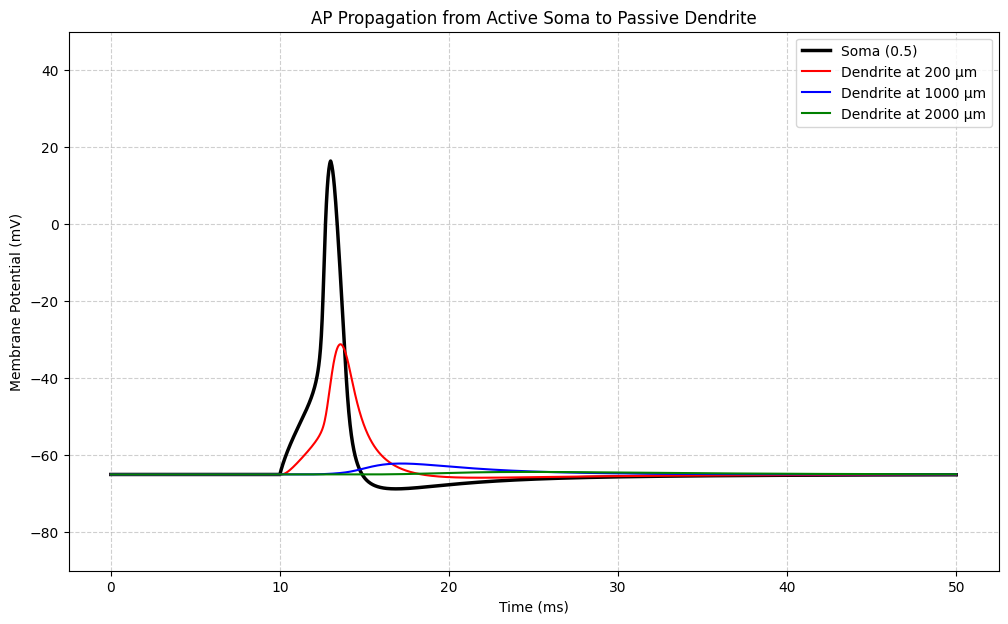

In [32]:
#@title Define and create the model { run: "auto" }
# --- 0. Create the sliders ---
Ldend = 2000 #@param {type:"slider", min:50, max:2000, step:10}


# --- 1. Create the Cell Components ---
soma = n.Section(name='soma')
soma.L = soma.diam = 20
soma.insert('wb') # Active soma

dend = n.Section(name='dend')
dend.L = Ldend     # A long dendrite (um)
dend.diam = 2    # Thinner than the soma
dend.nseg = 51   # Segment for spatial accuracy (d_lambda rule)


# --- 2. Define Passive Properties for the Dendrite ---
dend.insert('pas') # NEURON's built-in passive mechanism
dend.Ra = 150      # Axial resistance (Ohm-cm)
dend.cm = 1        # Membrane capacitance (uF/cm^2)
# Set leak conductance, g_pas = 1/Rm. Rm=15000 Ohm-cm^2
for seg in dend:
    seg.pas.g = 1/15000
    seg.pas.e = -65 # Leak reversal potential

# --- 3. Connect the Dendrite to the Soma ---
# connect(child(location), parent(location))
dend.connect(soma(1)) # Connect the start of the dendrite (0) to the end of the soma (1)

n("forall { nseg = int((L/(0.1*lambda_f(100))+0.9)/2)*2 + 1 }")  # set the number


stim = n.IClamp(soma(0.5))
stim.delay = 10
stim.dur = 3
stim.amp = 0.25

# --- 5. Set up Recording at Multiple Locations ---
t_vec = n.Vector().record(n._ref_t)
v_soma = n.Vector().record(soma(0.5)._ref_v)
v_dend_start = n.Vector().record(dend(0.1)._ref_v) # Near the soma
v_dend_mid = n.Vector().record(dend(0.5)._ref_v)   # Middle of dendrite
v_dend_end = n.Vector().record(dend(1.0)._ref_v)   # End of dendrite

# --- 6. Run the Simulation ---
n.v_init = -65
n.t = 0
n.tstop = 50
n.run()

# --- 7. Plot the Results ---
plt.figure(figsize=(12, 7))
plt.plot(t_vec, v_soma, label='Soma (0.5)', color='black', linewidth=2.5)
plt.plot(t_vec, v_dend_start, label=f'Dendrite at {0.1 * dend.L:.0f} µm', color='red', linestyle='-')
plt.plot(t_vec, v_dend_mid, label=f'Dendrite at {0.5 * dend.L:.0f} µm', color='blue', linestyle='-')
plt.plot(t_vec, v_dend_end, label=f'Dendrite at {1.0 * dend.L:.0f} µm', color='green', linestyle='-')

plt.title("AP Propagation from Active Soma to Passive Dendrite")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.ylim([-90, 50])


(-80.0, 30.0)

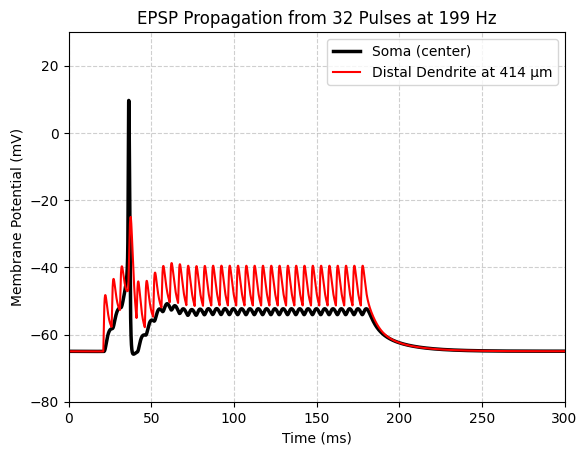

In [72]:
# @title Distal synaptic inputs - the longer the dendrite the weaker is somatic depolarization { run: "auto" }
from neuron import h
import matplotlib.pyplot as plt
import numpy as np

# Load the compiled mechanisms
h.load_file('stdrun.hoc')

T = 300
# --- 1. Simulation Parameters ---
Ldend = 460 #@param {type:"slider", min:50, max:2000, step:10}
SYN_AMPLITUDE = 0.005 #@param {type:"slider", min:0, max:1, step:0.005}
SYN_FREQUENCY = 199 #@param {type:"slider", min:1, max:200, step:3}
SYN_PULSES = 32 #@param {type:"slider", min:0, max:50, step:1}

# These are now at the top for easy modification
#SYN_AMPLITUDE = 0.005  # (uS) - controls the peak conductance
#SYN_FREQUENCY = 20     # (Hz) - frequency of synaptic activation
#SYN_PULSES = 3         # Number of presynaptic pulses

# --- 2. Create the Cell Components ---
soma = h.Section(name='soma')
soma.L = soma.diam = 20
soma.insert('wb') # Active soma

dend = h.Section(name='dend')
dend.L = Ldend   # A long dendrite (um)
dend.diam = 2    # Thinner than the soma
dend.nseg = 51   # Segment for spatial accuracy

# --- 3. Define Passive Properties for the Dendrite ---
dend.insert('pas')
dend.Ra = 150
dend.cm = 1
for seg in dend:
    seg.pas.g = 1/15000
    seg.pas.e = -65

# --- 4. Connect the Dendrite to the Soma ---
dend.connect(soma(1))

# --- 5. Create the Synapse ---
# We use Exp2Syn and set tau1=tau2 to create an alpha function.
# Place it on the distal dendrite (90% of the way down).
synapse = h.Exp2Syn(dend(0.9))
synapse.e = 0      # Excitatory synapse (reversal potential in mV)
synapse.tau1 = 0.5 # Rise time constant (ms)
synapse.tau2 = 0.5 # Decay time constant (ms), making it an alpha synapse

# --- 6. Create the Synaptic Stimulator (NetStim) ---
# This object will generate the event train to trigger the synapse.
netstim = h.NetStim()
netstim.number = SYN_PULSES          # Number of spikes in the train
netstim.interval = 1000 / SYN_FREQUENCY # Interval between spikes (ms)
netstim.start = 20                   # Time of first spike (ms)
netstim.noise = 0                    # No randomness

# --- 7. Connect the Stimulator to the Synapse (NetCon) ---
# A NetCon object delivers events from a source (NetStim) to a target (synapse).
netcon = h.NetCon(netstim, synapse)
netcon.delay = 1       # Synaptic delay (ms)
netcon.weight[0] = SYN_AMPLITUDE # Synaptic weight (strength) in microsiemens (uS)

# --- 8. Set up Recording ---
t_vec = h.Vector().record(h._ref_t)
v_soma = h.Vector().record(soma(0.5)._ref_v)
v_dend_distal = h.Vector().record(dend(0.9)._ref_v) # Record at the synapse location

# --- 9. Run the Simulation ---
h.v_init = -65
h.tstop = T # Longer simulation to see the full train
h.run()

# --- 10. Plot the Results ---
plt.plot(t_vec, v_soma, label='Soma (center)', color='black', linewidth=2.5)
plt.plot(t_vec, v_dend_distal, label=f'Distal Dendrite at {0.9 * dend.L:.0f} µm', color='red', linestyle='-')
plt.title(f"EPSP Propagation from {SYN_PULSES} Pulses at {SYN_FREQUENCY} Hz")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, T)
plt.ylim(-80, 30)